In [18]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [19]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [20]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, text

#from sqlalchemy.ext.declarative import declarative_base
#from sqlalchemy import Column, Integer, String, Float, Date
#from sqlalchemy.orm import sessionmaker
#import datetime as dt
#import pandas as pd
#import matplotlib.pyplot as plt

In [27]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")
conn = engine.connect()

In [28]:
# reflect an existing database into a new model
#Base.metadata.create_all(engine)
Base = automap_base()

# reflect the tables
Base.prepare(autoload_with=engine)


In [29]:
# View all of the classes that automap found
Base.classes.keys()

['station', 'measurement']

In [30]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [31]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [35]:
# Find the most recent date in the data set.
most_recent_date = session.query(func.max(measurement.date)).scalar()
print(most_recent_date)

2017-08-23


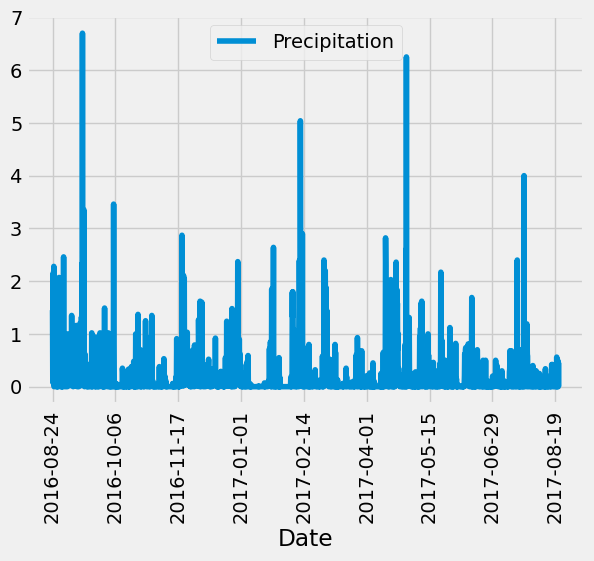

In [40]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. '

# Calculate the date one year from the last date in data set.
last_year = dt.datetime.strptime(most_recent_date, "%Y-%m-%d") - dt.timedelta(days=365)

# Perform a query to retrieve the data and precipitation scores
precip_data = session.query(measurement.date, measurement.prcp).filter(measurement.date >= last_year).order_by(measurement.date.desc()).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precip_df = pd.DataFrame(precip_data, columns=['Date', 'Precipitation']).dropna().sort_values('Date')

# Sort the dataframe by date
sorted_df = precip_df.sort_values(by='Date')

# Use Pandas Plotting with Matplotlib to plot the data
chart = sorted_df.plot(x='Date', y='Precipitation')
plt.xticks(rotation=90)
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_df.describe()

,Precipitation
count,2021.000000
mean,0.177279
std,0.461190
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [43]:
# Design a query to calculate the total number of stations in the dataset
total_stations = session.query(func.count(station.station)).scalar()
print(total_stations)

9


In [44]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
active_stations = session.query(station.station, func.count(measurement.id).label('measurements'))\
                         .join(measurement, station.station == measurement.station)\
                         .group_by(station.station)\
                         .order_by(func.count(measurement.id).desc())\
                         .all()

for station, count in active_stations:
    print(station, count)

USC00519281 2772
USC00519397 2724
USC00513117 2709
USC00519523 2669
USC00516128 2612
USC00514830 2202
USC00511918 1979
USC00517948 1372
USC00518838 511


In [47]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
station_id = 'USC00519281'

# Query to get the min, max, and avg temperature for the most active station
temperature_stats = session.query(func.min(measurement.tobs), 
                                  func.max(measurement.tobs), 
                                  func.avg(measurement.tobs))\
                           .filter(measurement.station == station_id)\
                           .all()

print(temperature_stats)

[(54.0, 85.0, 71.66378066378067)]


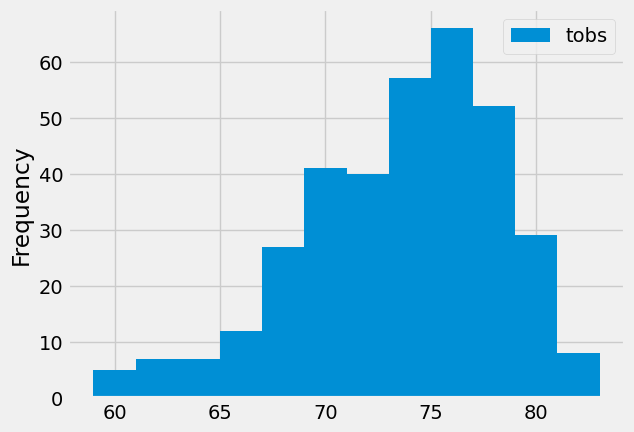

In [50]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
temp_data = session.query(measurement.date, measurement.tobs)\
                   .filter(measurement.station == station_id)\
                   .filter(measurement.date >= last_year)\
                   .all()

temp_df = pd.DataFrame(temp_data, columns=['Date', 'tobs'])

plt.hist(temp_df['tobs'], bins=12, label='tobs')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Close Session

In [51]:
# Close Session
session.close()